# DEEP LEARNING FOR COMPUTER VISION: <br> A PRACTITIONER'S VIEWPOINT

### André Panisson <br> Alan Perotti 
#### ISI Foundation
---

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Common Use Cases

In this notebook we simulate a few use cases that might happen when running computer vision experiments.

What happens when the number of images in the training set is small? What we might expect when we increase the number of images to train complex models with many convolutional layers?

With the following function, we load the CIFAR-10 dataset and select a subset of $N$ images for the training set and $N$ images for the validation set:

In [2]:
from keras.datasets import cifar10
from keras.utils import to_categorical

cifar_data = cifar10.load_data()
n_input = 32*32*3 # CIFAR data input (img shape: 32*32 * 3 channels)
n_classes = 10 # CIFAR total classes

def get_data(N):
    
    (X_train, Y_train), (X_test, Y_test) = cifar_data
    X_train, Y_train, X_test, Y_test = X_train[:N], Y_train[:N], X_test[:N], Y_test[:N]

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    Y_train = to_categorical(Y_train, n_classes)
    Y_test = to_categorical(Y_test, n_classes)
    
    return X_train, Y_train, X_test, Y_test

Using TensorFlow backend.


In the next, we define a Convolutional Neural Network with the following architecture:

- input: images with (32x32x3) pixels
- conv layer with 16 5x5 filters, padding=same and ReLU activation
- 2x2 max pool layer
- conv layer with 20 5x5 filters, padding=same and ReLU activation
- 2x2 max pool layer
- conv layer with 20 5x5 filters, padding=same and ReLU activation
- 2x2 max pool layer
- dropout layer
- fully connected layer with 10 neurons (10 classes) and softmax activation

The function `conv_model` takes as argument the rate for the dropout layer. With this parameter, we can control the fraction of input units that are deactivated at each update during training time.

By default, the dropout rate is set to be very small, which means that all input units (320 in this case) will be activatet during training time.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D

def conv_model(dropout_rate=0.01):
    # create model
    model = Sequential()
    model.add(Convolution2D(16, (5, 5), padding='same', input_shape=(32, 32, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(20, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(20, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

conv_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 20)        8020      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
__________

The next function defines how we run each experiment.

We start by selecting $N$ images for the training set and $N$ images for the validation set. We create the convolutional neural network as defined above, with the given dropout rate. Then, we save the model to disk, evaluate the model using the validation set and plot the curves showing the evolution of loss and accuracy for each trained epoch, for the training set and for the validation set.

This function has also the ability of loading a model if it was trained previously.

In [4]:
from keras.models import load_model
import pickle

def plot_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].plot(history['loss'])
    ax[0].plot(history['val_loss'])
    ax[0].legend(['Training', 'Validation'])

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(history['acc'])
    ax[1].plot(history['val_acc'])
    ax[1].legend(['Training', 'Validation'], loc='lower right')

def run_experiment(N, conv_model=conv_model, dropout_rate=0.01, epochs=100, overwrite=False):
    
    X_train, Y_train, X_test, Y_test = get_data(N)

    model_name = "conv_n{}_dr{:.2f}_e{}".format(N, dropout_rate, epochs)
    loaded = False
    
    if not overwrite:
        try:
            model = load_model("models/%s.hdf5" % model_name)
            with open("models/%s.hist" % model_name, 'br') as fh:
                history = pickle.load(fh)
            loaded = True
        except:
            pass
        
    if overwrite or not loaded:
        model = conv_model(dropout_rate)

        print("Training model...")
        # Fit the model
        hist = model.fit(X_train, Y_train,
                  validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=32, verbose=1)
        history = hist.history
        model.save("models/%s.hdf5" % model_name)
        with open("models/%s.hist" % model_name, 'bw') as fh:
            pickle.dump(history, fh)
    
    # Evaluation of the model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))

    plot_curves(history)

### Case 1

**Small data, a complex model to train.**  
In this case, we have 100 images for training and 100 images for validation. We use the default dropout rate (all units will be active during training phase).

Baseline Error: 79.00%


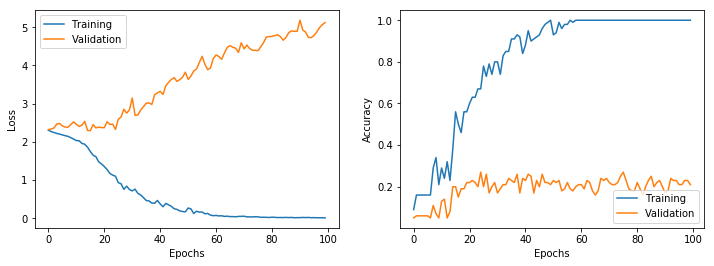

In [6]:
run_experiment(100)

The training loss declines at each epoch, but validation loss doesn't decline at all. We end up with a perfect classification score in the training set, but a bad accuracy for the validation set.

### Case 2

**Some more data, a complex model to train.**   
In this case, we have 200 images for training and 200 images for validation. We use the default dropout rate (all units will be active during training phase).

Baseline Error: 72.00%


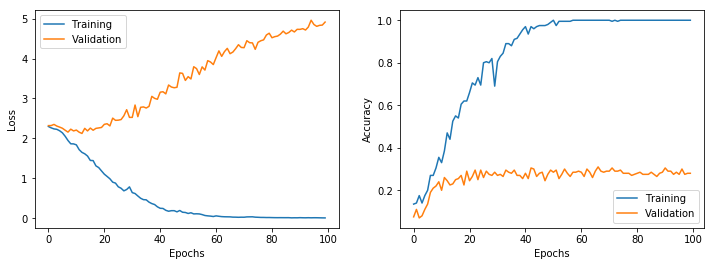

In [17]:
run_experiment(200)

The training loss declines at each epoch, and validation loss starts to decline at the beginning, but starts to grow again. We end up again with a perfect classification score in the training set, and the accuracy for the validation set is a bit better than before.

### Case 3

We keep increasing the number of samples (500), still a complex model to train.  
In this case, we use 500 images for training and 500 images for validation. We use the default dropout rate (all units will be active during training phase).

Baseline Error: 64.20%


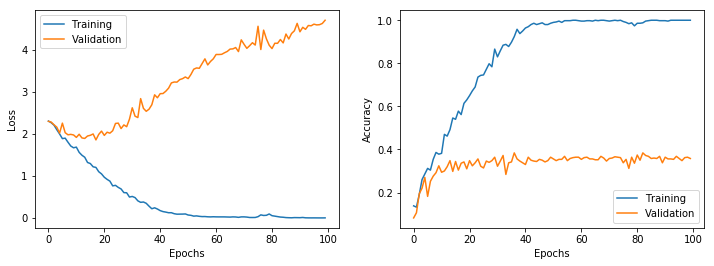

In [12]:
run_experiment(500)

The training loss declines at each epoch, and validation loss starts to decline at the beginning, but starts to grow again. We end up again with a perfect classification score in the training set, and the accuracy for the validation set better than previous cases.

### Case 4

**Small data, less complex model.**  
In this case, we have 200 images for training and 200 images for validation. We use a dropout rate of 0.6, meaning that at each training step 60% of the units in the last layer will be deactivated.

Baseline Error: 69.00%


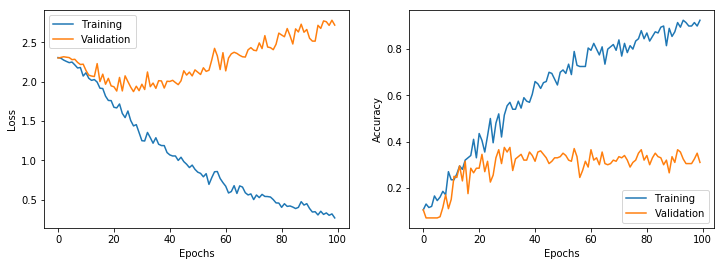

In [22]:
run_experiment(200, dropout_rate=0.6)

The training loss declines at each epoch, and validation loss starts to decline at the beginning, and again starts to grow again, but the grow is more limited. We end up with a classification score that is not perfect for the training set, and the accuracy for the validation set better than previous case where we used the same number of samples for training.

### Case 5

**More data, less complex model.**   
In this case, we use 500 images for training and 500 images for validation. We use a dropout rate of 0.8, meaning that at each training step 80% of the units in the last layer will be deactivated.

Baseline Error: 60.20%


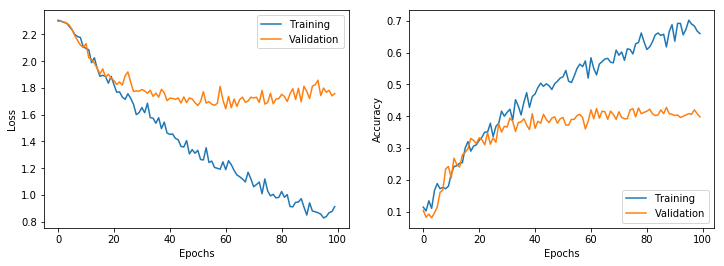

In [26]:
run_experiment(500, dropout_rate=0.8)

The training loss declines at each epoch, and validation loss starts to decline at the beginning, and then stabilizes. We end up with a classification score that is much lower for the training set, and the accuracy for the validation set better than previous cases.

---
In the next notebook, we will use a bit of learning theory to understand what is happening in these cases.